In [77]:
import os
import math
import time
import random
import argparse
import numpy as np
from tqdm import trange
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils import tensorboard as tb

from maze import Maze

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
opt = SimpleNamespace(latent_dim = 128, size = 32, channels = 1, seed = 4)
opt = SimpleNamespace(**vars(opt), img_size = opt.size + int(opt.size % 2 == 0))

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(opt.seed)

Tensor = torch.FloatTensor

In [52]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, _pad = False):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        if _pad:
            new_size = img.size(2) + 1
            img_padded = torch.ones((img.size(0), 1, new_size, new_size))
            img_padded[:, :, 1:, 1:] = img
            return img_padded
        else:
            return img

In [53]:
generator = Generator()
# generator.apply(weights_init_normal)

In [55]:
generator.load_state_dict(torch.load("bgan32/generator.pt"))

<All keys matched successfully>

In [112]:
def get_tile(size):
    z = Variable(Tensor(np.random.normal(0, 1, (size * size, opt.latent_dim))))
    gen_imgs = generator(z).squeeze().detach().numpy()
    gen_imgs[gen_imgs >= 0.5] = 1
    gen_imgs[gen_imgs < 0.5] = 0
    
    # now we reshape this shit
    all_, dim, _ = gen_imgs.shape
    count = int(math.sqrt(all_))
    tile = np.zeros((count*dim, count*dim))
    
    for i in range(count):
        for j in range(count):
            idx = i*count + j

            # not that x-y matters but still
            x_start_idx = j*dim
            x_end_idx = (j+1)*dim
            y_start_idx = i*dim
            y_end_idx = (i+1)*dim

            tile[x_start_idx:x_end_idx, y_start_idx:y_end_idx] = gen_imgs[idx]

    return tile

In [113]:
tile = get_tile(5)

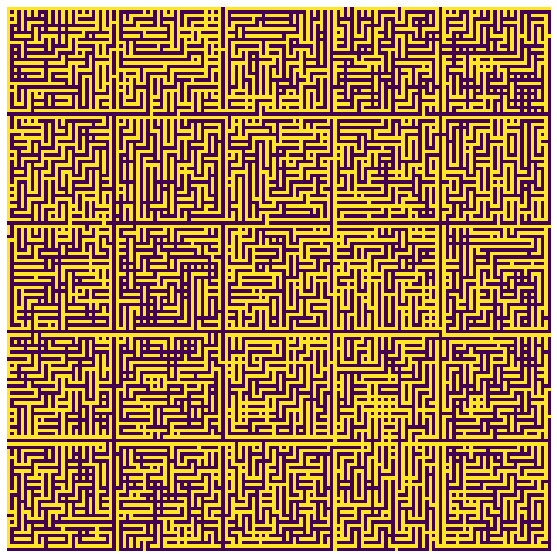

In [123]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(tile)

In [72]:
gen_imgs.shape

(32, 32, 32)

In [14]:
generator.state_dict()

OrderedDict([('l1.0.weight',
              tensor([[ 0.0076,  0.0033,  0.0029,  ...,  0.0638,  0.0858, -0.0431],
                      [-0.0616, -0.0090,  0.0651,  ...,  0.0149,  0.0646,  0.0373],
                      [ 0.0290,  0.0622,  0.0239,  ...,  0.0808, -0.0793,  0.0407],
                      ...,
                      [-0.0535,  0.0398,  0.0218,  ...,  0.0867,  0.0717, -0.0493],
                      [ 0.0719,  0.0384, -0.0819,  ..., -0.0805, -0.0451,  0.0012],
                      [-0.0037, -0.0268,  0.0171,  ..., -0.0101, -0.0663,  0.0522]])),
             ('l1.0.bias',
              tensor([-0.0317,  0.0398,  0.0059,  ..., -0.0613, -0.0750,  0.0142])),
             ('conv_blocks.0.weight',
              tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
     